In [1]:
import yfinance as yf
import pandas as pd
from scipy.stats import skew, kurtosis
import numpy as np


In [2]:

def round_to_sf(number, sf):
    """Round number to specified significant figures."""
    return round(number, sf - int(np.floor(np.log10(abs(number)))) - 1)

def compute_summary_statistics(stock_data):
    """
    Compute summary statistics for weekly returns of multiple stocks.

    Parameters:
    - stock_data: DataFrame where columns are stock tickers and rows represent weekly returns.

    Returns:
    - summary_df: DataFrame with summary statistics for each stock.
    """
    # Initializing an empty DataFrame for summary statistics
    summary_df = pd.DataFrame(index=['Min', 'Max', 'Mean', 'Std', 'Skewness', 'Kurtosis'])

    # Looping through each stock and computing the statistics
    for stock in stock_data.columns:
        stock_returns = stock_data[stock].dropna()  # Remove NaN values
        stats = {
            'Min': round_to_sf(stock_returns.min(), 4),
            'Max': round_to_sf(stock_returns.max(), 4),
            'Mean': round_to_sf(stock_returns.mean(), 4),
            'Std': round_to_sf(stock_returns.std(), 4),
            'Skewness': round_to_sf(skew(stock_returns), 4),
            'Kurtosis': round_to_sf(kurtosis(stock_returns), 4)
        }
        summary_df[stock] = stats.values()

    return summary_df

# Example usage:
# Assuming 'weekly_returns_df' is your DataFrame containing weekly returns for multiple stocks
# summary_statistics = compute_summary_statistics(weekly_returns_df)
# print(summary_statistics)


In [4]:
import yfinance as yf

Start='2008-01-01'; End='2015-12-31'; 
asset = ['DHR','GILD','ISRG','JNJ','LLY','PFE','REGN','TMO','AZN','MRK']

Database=yf.download(asset,Start, End, progress=False).resample('W-FRI').last()['Adj Close']
Database
compute_summary_statistics(Database)

,AZN,DHR,GILD,ISRG,JNJ,LLY,MRK,PFE,REGN,TMO
Min,8.5250,15.5100,11.9800,10.1100,31.3400,17.87000,13.1200,6.8030,12.670,28.3500
Max,29.4400,62.5500,90.1900,65.0900,85.6300,75.24000,45.8700,25.2300,579.600,139.8000
Mean,16.9100,34.9700,34.5600,42.2300,54.8800,36.72000,27.9900,14.7900,165.000,71.4400
Std,5.5160,12.6000,24.8300,13.7900,16.3600,14.95000,9.1240,5.3230,170.000,32.5400
Skewness,0.7349,0.4234,0.9505,-0.4596,0.6116,1.00800,0.4299,0.3918,0.932,0.7418
Kurtosis,-0.8085,-1.0230,-0.7131,-0.6289,-1.2350,-0.03896,-1.1380,-1.3080,-0.415,-1.0280


In [6]:
Database.to_csv('ADF_test.csv')

### ADF fuller test

In [10]:
# Reload the CSV file and display its structure
df = pd.read_csv('./ADF_test.csv')
df.head()

,Date,AZN,DHR,GILD,ISRG,JNJ,LLY,MRK,PFE,REGN,TMO
0,2008-01-04,10.667050,26.595276,17.215483,33.888889,41.469315,31.279680,30.860548,11.588487,22.490000,53.344234
1,2008-01-11,11.627467,25.016628,18.258163,29.132221,42.754208,34.305008,32.869053,12.192534,24.290001,52.438324
2,2008-01-18,11.704301,24.156698,17.316755,29.118889,41.752758,32.433048,28.944307,11.420979,24.600000,49.606144
3,2008-01-25,10.987188,23.528997,16.154053,29.888889,39.340416,30.639608,25.942392,11.476815,21.900000,49.215168
4,2008-02-01,10.564603,23.827156,17.226738,33.956669,39.907280,31.195154,24.959854,11.974266,21.480000,49.949436


In [11]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and extract critical values
def perform_adf_test_with_critical_values(series):
    result = adfuller(series, autolag='AIC')
    return {
        "Test Statistic": result[0],
        "p-value": result[1],
        "1%": result[4]['1%'],
        "5%": result[4]['5%'],
        "10%": result[4]['10%'],
        "Stationarity": "Stationary" if result[1] < 0.05 else "Non-Stationary"
    }

# Perform ADF test for each ticker
adf_results_with_critical_values = {}
for ticker in df.columns[1:]:
    adf_results_with_critical_values[ticker] = perform_adf_test_with_critical_values(df[ticker].dropna())

adf_results_with_critical_values_df = pd.DataFrame(adf_results_with_critical_values).T
adf_results_with_critical_values_df



,Test Statistic,p-value,1%,5%,10%,Stationarity
AZN,-0.24218,0.933303,-3.44624,-2.86855,-2.5705,Non-Stationary
DHR,0.414082,0.982014,-3.44624,-2.86855,-2.5705,Non-Stationary
GILD,0.557684,0.986525,-3.44648,-2.86865,-2.57056,Non-Stationary
ISRG,-1.20463,0.671603,-3.44613,-2.8685,-2.57048,Non-Stationary
JNJ,0.214022,0.973037,-3.44613,-2.8685,-2.57048,Non-Stationary
LLY,2.18645,0.998871,-3.4468,-2.86879,-2.57063,Non-Stationary
MRK,-0.473654,0.897056,-3.44617,-2.86851,-2.57048,Non-Stationary
PFE,0.121198,0.967479,-3.44617,-2.86851,-2.57048,Non-Stationary
REGN,2.58175,0.999072,-3.44644,-2.86863,-2.57055,Non-Stationary
TMO,0.919341,0.993338,-3.44617,-2.86851,-2.57048,Non-Stationary


In [12]:
df = adf_results_with_critical_values_df.round({
    'Test Statistic': 2, 
    'p-value': 2, 
    '1%': 2, 
    '5%': 2, 
    '10%': 2
})
df

,Test Statistic,p-value,1%,5%,10%,Stationarity
AZN,-0.24218,0.933303,-3.44624,-2.86855,-2.5705,Non-Stationary
DHR,0.414082,0.982014,-3.44624,-2.86855,-2.5705,Non-Stationary
GILD,0.557684,0.986525,-3.44648,-2.86865,-2.57056,Non-Stationary
ISRG,-1.20463,0.671603,-3.44613,-2.8685,-2.57048,Non-Stationary
JNJ,0.214022,0.973037,-3.44613,-2.8685,-2.57048,Non-Stationary
LLY,2.18645,0.998871,-3.4468,-2.86879,-2.57063,Non-Stationary
MRK,-0.473654,0.897056,-3.44617,-2.86851,-2.57048,Non-Stationary
PFE,0.121198,0.967479,-3.44617,-2.86851,-2.57048,Non-Stationary
REGN,2.58175,0.999072,-3.44644,-2.86863,-2.57055,Non-Stationary
TMO,0.919341,0.993338,-3.44617,-2.86851,-2.57048,Non-Stationary


In [13]:
file_path = ('./stocks_healthcare.csv')
pd.read_csv(file_path, index_col='Date')

,AZN,DHR,GILD,ISRG,JNJ,LLY,MRK,PFE,REGN,TMO
Date,,,,,,,,,,
2008-01-04,10.667048,26.595272,17.215483,33.888889,41.469311,31.221991,30.860544,11.434323,22.490000,53.344238
2008-01-11,11.627466,25.016636,18.258158,29.132221,42.754196,34.241726,32.869045,12.030332,24.290001,52.438320
2008-01-18,11.704301,24.156687,17.316750,29.118889,41.752743,32.373238,28.944315,11.269050,24.600000,49.606144
2008-01-25,10.987190,23.529003,16.154051,29.888889,39.340416,30.583099,25.942392,11.324145,21.900000,49.215172
2008-02-01,10.564603,23.827152,17.226736,33.956669,39.907284,31.137613,24.959848,11.814973,21.480000,49.949444
...,...,...,...,...,...,...,...,...,...,...
2015-12-04,26.020716,62.024773,78.657364,57.933334,83.646202,73.982460,39.997017,23.007479,558.659973,133.974152
2015-12-11,25.506748,59.769444,75.603859,58.163334,82.614326,71.138306,39.222034,22.488407,534.510010,131.314774
2015-12-18,25.161539,58.714279,77.122032,59.353333,82.833672,72.402367,38.838455,22.439310,544.229980,131.618073


In [15]:
# Let's try loading the data again with a fresh approach
import pandas as pd

# Load the data
file_path = './stocks_healthcare.csv'

# Attempt to read the CSV file
try:
    stock_prices = pd.read_csv(file_path, index_col='Date')
    # Calculate log returns
    log_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()
    # Indicate success
    success = True
    result = log_returns.head()  # Show the first few rows of log returns
except Exception as e:
    # Indicate failure and show the error
    success = False
    result = str(e)

(success, result)


(True,
                  AZN       DHR      GILD      ISRG       JNJ       LLY  \
 Date                                                                     
 2008-01-11  0.086211 -0.061192  0.058803 -0.151242  0.030514  0.092322   
 2008-01-18  0.006586 -0.034980 -0.052938 -0.000458 -0.023702 -0.056113   
 2008-01-25 -0.063226 -0.026327 -0.069503  0.026100 -0.059513 -0.056885   
 2008-02-01 -0.039221  0.012592  0.064292  0.127598  0.014306  0.017969   
 2008-02-08 -0.049761 -0.035529 -0.030955 -0.016263 -0.021215 -0.028071   
 
                  MRK       PFE      REGN       TMO  
 Date                                                
 2008-01-11  0.063053  0.050811  0.076994 -0.017128  
 2008-01-18 -0.127158 -0.065371  0.012682 -0.055523  
 2008-01-25 -0.109495  0.004877 -0.116260 -0.007913  
 2008-02-01 -0.038610  0.042430 -0.019364  0.014809  
 2008-02-08 -0.032043 -0.042201 -0.093124  0.056416  )

In [20]:
pd.read_csv('./stocks_healthcare.csv', index_col='Date', parse_dates=True)

,AZN,DHR,GILD,ISRG
Date,,,,
2008-01-04,10.667048,26.595272,17.215483,33.888889
2008-01-11,11.627466,25.016636,18.258158,29.132221
2008-01-18,11.704301,24.156687,17.316750,29.118889
2008-01-25,10.987190,23.529003,16.154051,29.888889
2008-02-01,10.564603,23.827152,17.226736,33.956669
...,...,...,...,...
2015-12-04,26.020716,62.024773,78.657364,57.933334
2015-12-11,25.506748,59.769444,75.603859,58.163334
2015-12-18,25.161539,58.714279,77.122032,59.353333


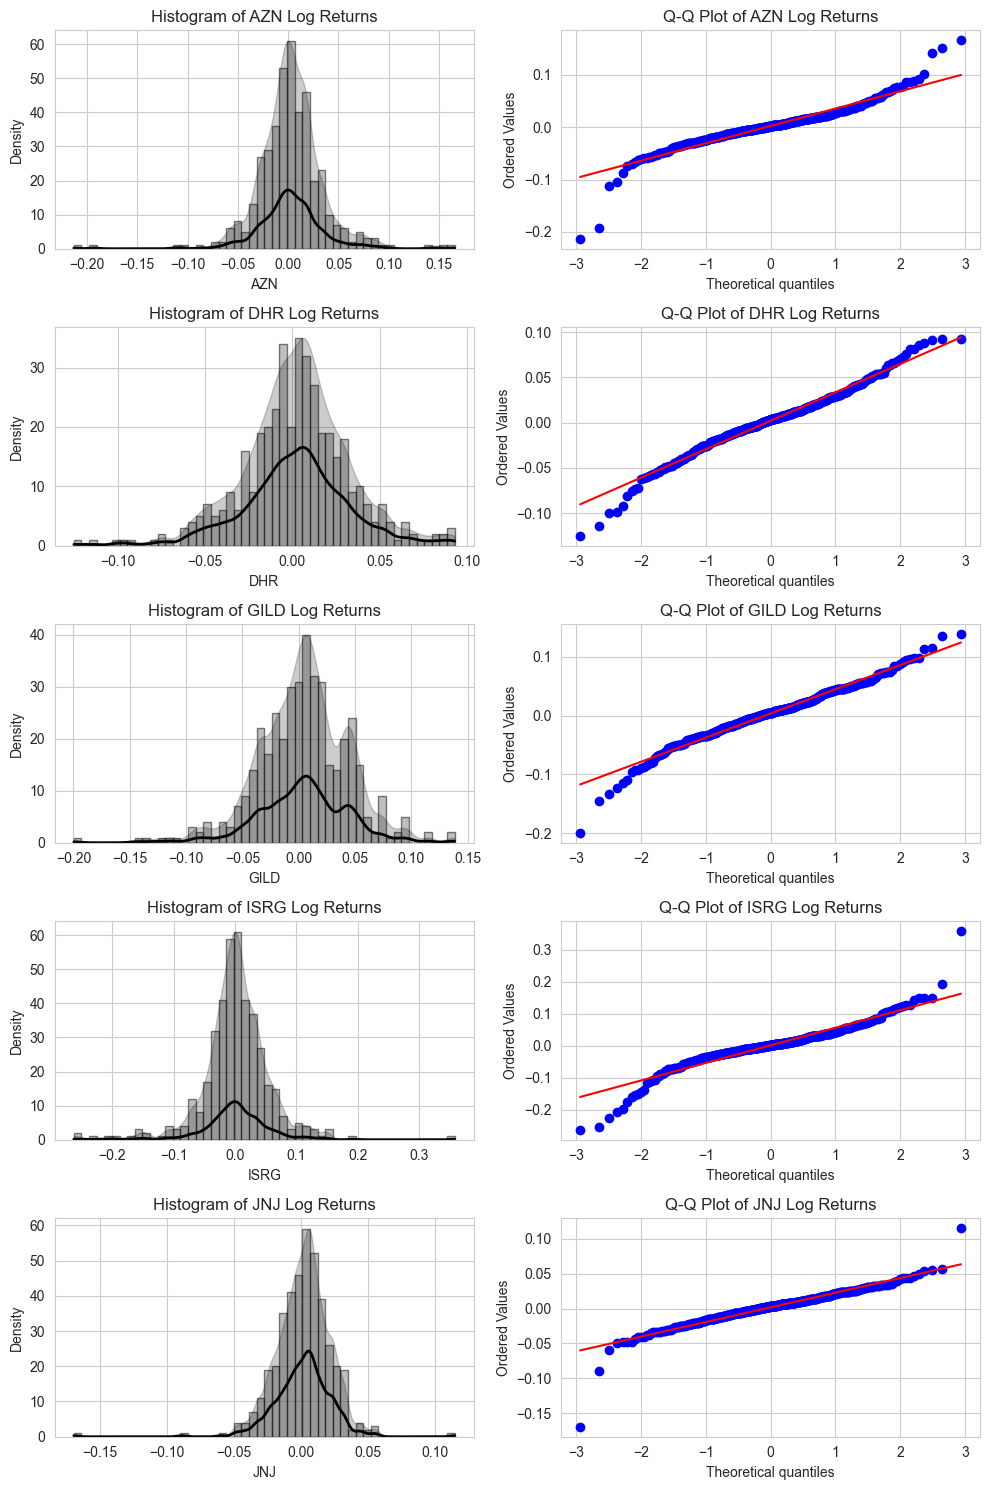

In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the stock prices data
stock_prices = pd.read_csv('./stocks_healthcare.csv', index_col='Date', parse_dates=True).iloc[:,:5]

# Calculate the log returns
log_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()

# Create Q-Q plots
fig, axes = plt.subplots(len(log_returns.columns), 2, figsize=(10, len(log_returns.columns)*3))
for i, col in enumerate(log_returns.columns):
    # Histogram for the log returns with gray bars and black edges
    # Note: density=False will plot the counts and not the density
    count, bins, ignored = axes[i, 0].hist(log_returns[col], bins=50, density=False, alpha=0.5, color='gray', edgecolor='black')
    
    # KDE plot adjusted to the scale of the histogram
    # Note: Using the same bins for the KDE plot as the histogram
    sns.kdeplot(log_returns[col], ax=axes[i, 0], color='black', linewidth=2, bw_adjust=0.5, cut=0)
    
    # Scaling the KDE plot by multiplying by the number of observations and the bin width to match the histogram scale
    kde_x, kde_y = axes[i, 0].lines[0].get_data()
    kde_scale = count.max() / kde_y.max()
    axes[i, 0].fill_between(kde_x, kde_y*kde_scale, alpha=0.2, color='black')
    
    axes[i, 0].set_title(f'Histogram of {col} Log Returns')

    # Q-Q plot for the log returns
    stats.probplot(log_returns[col], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot of {col} Log Returns')

plt.tight_layout()
plt.show()
